# Introduciton

The goal of this project is to train a neural network in order to identify if an image of body tissue collected from a pathology scan is cancerous or not. This is a binary classification problem, meaning that each training example is labeled as either being cancerous(1) or not cancerous(0). Cancerous in this case means that at least one pixel of the image contains tumorous tissue. 

The source of this data is this Kaggle competition: https://www.kaggle.com/competitions/histopathologic-cancer-detection

The dataset consists of 220025 training images that are all labeled with if they are cancerous or not. Additionally, there are 57458 unlabeled test images. The goal of this project for the built neural network to predict reasonably well the labels on this test set. The dataset does not come with test labels, so the test performance will be gotten by making submissions to the kaggle competition. 

# Import Libraries and Define Helper Functions

In [1]:
import os
import shutil
import json

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model

In [2]:
def display_random_images(image_data_array, N):
    """Displays N random images from the given image_data_array"""
    # Calculate the grid size
    grid_size = int(np.ceil(np.sqrt(N)))

    # Randomly select N images
    selected_images = np.random.choice(image_data_array.shape[0], N, replace=False)

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i, ax in enumerate(axs.flatten()):
        if i < N:
            ax.imshow(image_data_array[selected_images[i]])
            ax.axis('off')  # Turn off axis for each subplot
        else:
            fig.delaxes(ax)  # Remove excess subplots

    plt.tight_layout()
    plt.show()
    
def make_train_path(id_str):
    return os.path.join(r"./histopathologic-cancer-detection/train/", f"{id_str}.tif")

# Exploratory Data Analysis

Start by having a look at what one of these images look like and what structure it has. 

Image Shape = (96, 96, 3)


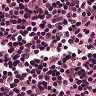

In [3]:
example_path = "./histopathologic-cancer-detection/train/0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.tif"
example_img = Image.open(example_path)
example_array = np.array(example_img)
print(f"Image Shape = {example_array.shape}")
example_img

The image is visually a collection of cells from a tissue sample. Its resolution 96x96 pixels and it is stored as an RGB image, meaning there are separate channels for red, green, and blue.

The training labels are stored in `train_labels.csv`, which allows the label of each image to be looked up using the id of the image, which comes from the filename of each image file. 

This labels file will be loaded into a data frame to confirm its structure. Additionally, the filename of each training image will be added, which will be useful for loading in the data in bulk later on. 

In [4]:
train_labels_path = r"./histopathologic-cancer-detection/train_labels.csv"
train_labels_df = pd.read_csv(train_labels_path)
train_labels_df["filename"] = train_labels_df["id"].apply(make_train_path)
train_labels_df["label"] = train_labels_df["label"].astype(str)
train_labels_df.head()

id label  \
0  f38a6374c348f90b587e046aac6079959adf3835     0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77     1   
2  755db6279dae599ebb4d39a9123cce439965282d     0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0   
4  068aba587a4950175d04c680d38943fd488d6a9d     0   

                                            filename  
0  ./histopathologic-cancer-detection/train/f38a6...  
1  ./histopathologic-cancer-detection/train/c18f2...  
2  ./histopathologic-cancer-detection/train/755db...  
3  ./histopathologic-cancer-detection/train/bc3f0...  
4  ./histopathologic-cancer-detection/train/068ab...

Check to see how balanced the dataset is by visualizing what percentage of the training dataset is cancerous(1) and what percentage is non-cancerous(0).

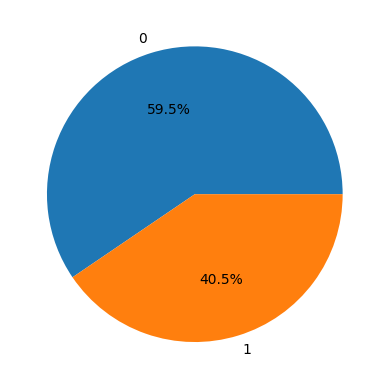

In [5]:
unique_labels, counts = np.unique(train_labels_df.label.values, return_counts=True)
plt.pie(counts/np.sum(counts), labels=unique_labels, autopct='%1.1f%%')
plt.show()

Cancerous examples only make up 40.5% of the dataset while non-cancerous examples make up the remaining 59.5. While this is slightly imbalanced, it is not imbalanced enough to perform any operations to balance the dataset, at least not on the first pass.

Next, a small subset of the training images will be loaded in (200 images) and will be used to visualize each of the classes individually to see if there are any visually obvious features of each class.

In [6]:
sample_data = np.empty((200, 96, 96, 3), dtype=np.uint8)
sample_labels = np.empty(200, dtype=np.int8)
for i in range(len(train_labels_df))[:200]:
    img_path = make_train_path(train_labels_df.id.values[i])
    img = Image.open(img_path)
    sample_data[i] = np.array(img)
    sample_labels[i] = train_labels_df.label.values[i]

Display 64 random images that are non-cancerous and 64 random images that are cancerous. 

Non-Cancerous Images


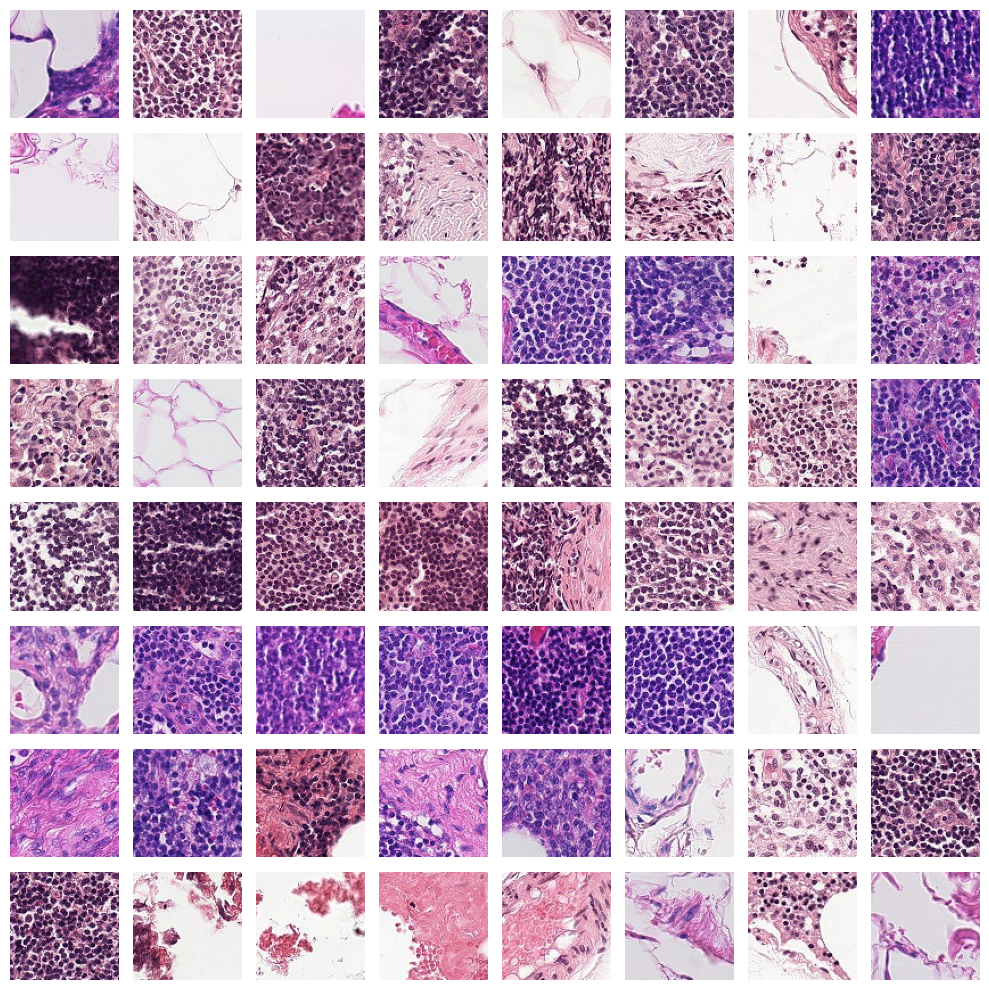

In [7]:
print("Non-Cancerous Images")
display_random_images(sample_data[sample_labels == 0], 64)

Cancerous Images


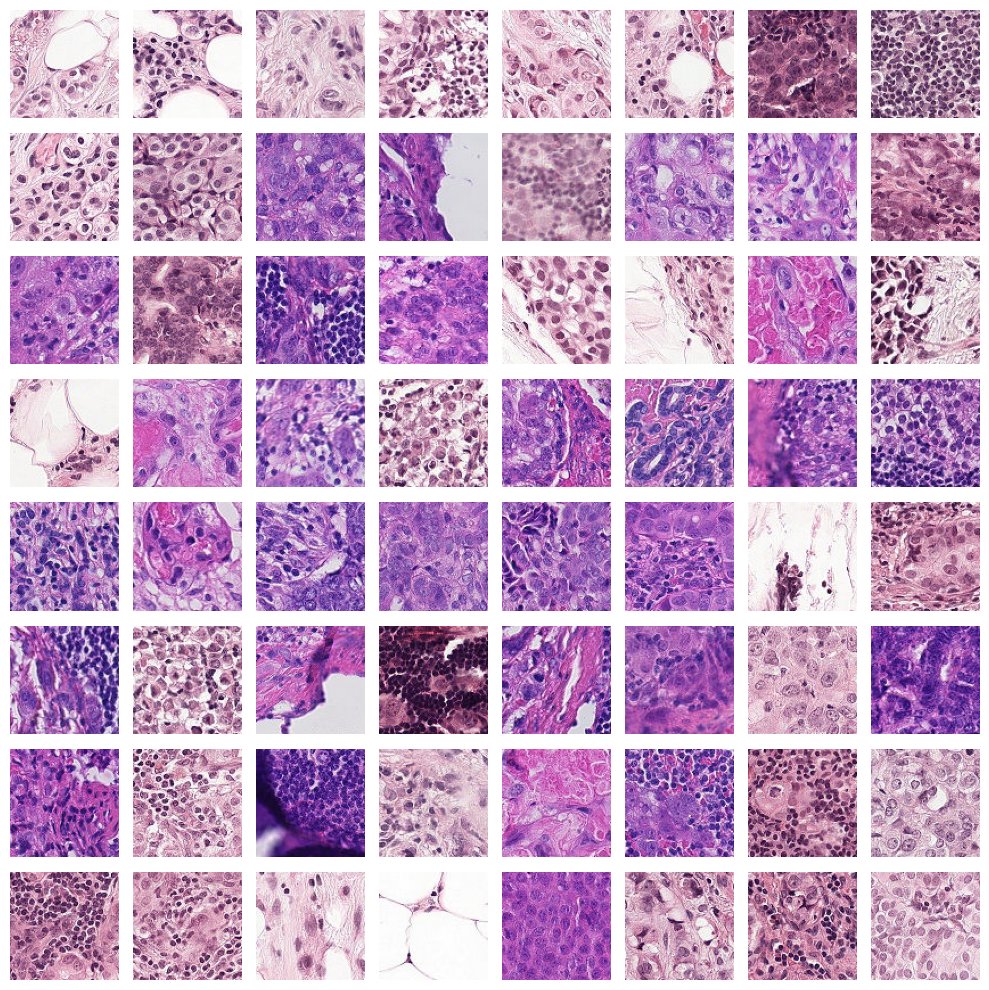

In [8]:
print("Cancerous Images")
display_random_images(sample_data[sample_labels == 1], 64)

Both the cancerous and non-cancerous images visually seem to contain similar features. Both sets of images are very diverse and contain features such as small collections of purple cells, big white blobs, and dark patches. Without proper medical training, it is difficult to come up with any features visually that distinguish a cancerous image from a non-cancerous one. Hopefully a neural network can do better. 

# Data Generators

The training set for this task is very large, consisting of 220025 96x96x3 images, which works out to be 5.72 GB of data. It would be impractical to load in and store all of this data at once. Therefore a technique called batch loading will be used which loads images into memory in batches as they are needed for training and then replaces them with the next batch. This way, only one batch of images are in memory at a given time, which significantly reduces the memory necessary for training.

Start by defining an `ImageDataGenerator` object. It will preprocess the images by rescaling them so each pixel is between 0 and 1 and also perform an 80/20 train-validation split. 

In [9]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

Now define the train and validation generators, the will read in images based on the filepaths specified in `train_labels_df` and store their labels based on the labels in that dataframe. A batch size of 32 images will be used.  

In [10]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="training"
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


A generator will also be made for the test data. First a similar dataframe `test_df` must be made which is in the same format as `train_labels_df`, just without a column for labels. 

In [11]:
test_path = "./histopathologic-cancer-detection/test"
test_ids = [filename[:-4] for filename in os.listdir(test_path)]
test_filenames = [os.path.join(test_path, filename) for filename in os.listdir(test_path)]
test_df = pd.DataFrame()
test_df["id"] = test_ids
test_df["filename"] = test_filenames

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=64,
    shuffle=False,
    class_mode=None
)

Found 57458 validated image filenames.


# Model Training Funciton

Next define some functions for training neural networks. Several neural networks will be trained so defining these functions significantly cuts down on shared code. 

The first function train_model is responsible for performing the model training. It takes in an untrained model and trains it based on the training data, also using validation data to monitor the model's performance and using early stopping to prevent overfitting. This early stopping occurs if the validation loss has not improved for 10 epochs. The function saves the training history and dumps both the trained model and the history to a file when it is done training, allowing the model to be loaded back in if necessary. If load_from_file is true, the model and history will be loaded in from file rather than retrained.

Once a model is either trained or loaded, if plot is true, it will create a plot visualizing the training and validation loss, accuracy, and AUC over the training epochs. If run_test is true, it will run the second function make_output_csv, which processes the test data and outputs the results in an appropriate format to be submitted to the Kaggle competition for evaluation.

Finally, a summary of the epoch with the lowest validation loss (which is the epoch whose weights are saved in the model after early stopping) is printed and that summary information is also returned. 

In [12]:
def train_model(model, train_generator, validation_generator, test_generator, folder_path, load_from_file, plot=True, run_test=True):
    np.random.seed(42)
    tf.random.set_seed(42)
    
    checkpoint_path = os.path.join(folder_path, "model.ckpt")
    history_path = os.path.join(folder_path, "history.json")
    
    os.makedirs(folder_path, exist_ok=True)
    
    if load_from_file:
        print("Loading Model from File")
        model.load_weights(checkpoint_path)
        with open(history_path) as f:
            history = json.load(f)
            
    else:
        shutil.rmtree(folder_path)
        checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1, save_best_only=True)
        early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1)


        history = model.fit(train_generator,
                            steps_per_epoch=len(train_generator),
                            validation_data=validation_generator,
                            validation_steps=len(validation_generator),
                            epochs=100,
                            callbacks=[early_stopping, checkpoint]).history

        with open(history_path, "w+") as f:
            json.dump(history, f)
            
    if plot:
        epochs = np.arange(1, len(history["val_loss"]) + 1, 1)
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].plot(epochs, history["loss"], label="train")
        axs[0].plot(epochs, history["val_loss"], label="validation")
        axs[0].set_title('Model loss')
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].legend()

        axs[1].plot(epochs, history["accuracy"], label="train")
        axs[1].plot(epochs, history["val_accuracy"], label="validation")
        axs[1].set_title('Model accuracy')
        axs[1].set_ylabel('Accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].legend()

        axs[2].plot(epochs, history["auc"], label="train")
        axs[2].plot(epochs, history["val_auc"], label="validation")
        axs[2].set_title('Model AUC')
        axs[2].set_ylabel('AUC')
        axs[2].set_xlabel('Epoch')
        axs[2].legend()

        plt.tight_layout()
        plt.show()
        
    if run_test:
        make_output_csv(model, test_generator, folder_path)
        
    i_min = np.argmin(history["val_loss"])
    best_epoch = i_min+1
    best_loss = history['val_loss'][i_min]
    best_accuracy = history['val_accuracy'][i_min]
    best_auc = history['val_auc'][i_min]
    
    
    return best_epoch, best_loss, best_accuracy, best_auc

def make_output_csv(model, test_generator, folder_path):
    """Runs the test data in test_generator aganist a trained model and outputs the results to test_labels.csv in the specified folder"""
    test_probs = model.predict(test_generator)
    test_labels = np.round(test_probs).astype(int).flatten()
    out_df = pd.DataFrame()
    out_df["id"] = test_ids
    out_df["label"] = test_labels
    out_df.to_csv(os.path.join(folder_path, "test_labels.csv"), index=False)

# Fully Connected

The first model that will be trained for this problem is a simple, dense fully connected neural network. It will have one hidden layer with 128 nodes that uses a ReLU activation function and a single output node that uses a sigmoid activation function.

As this is a binary classification problem, binary cross entropy will be used as the loss function and the ADAM optimizer will be used. In addition to the loss, the metrics of accuracy and AUC will be monitored. All future models will also be compiled in the same way. 

In [13]:
dense_model = Sequential()
dense_model.add(Flatten(input_shape=(96, 96, 3)))
dense_model.add(Dense(128, activation="relu"))
dense_model.add(Dense(1, activation="sigmoid"))

dense_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 128)               3539072   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,539,201
Trainable params: 3,539,201
Non-trainable params: 0
_________________________________________________________________


Loading Model from File


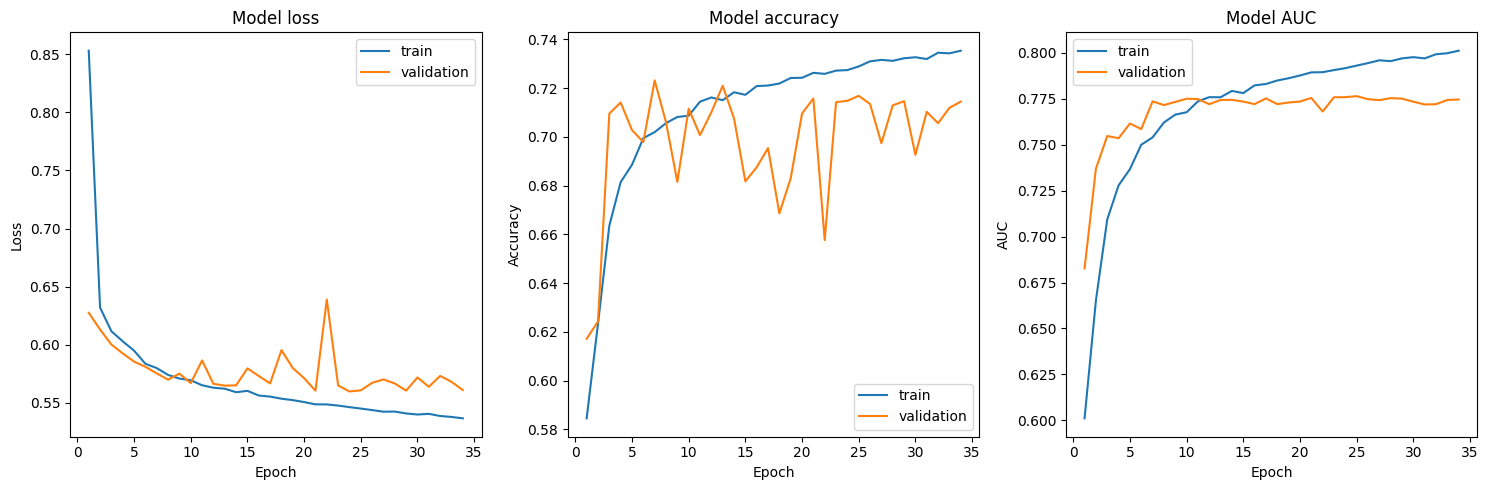

Best Epoch: 24
Best Model Loss: 0.5597664713859558
Best Model Accuracy: 0.714827835559845
Best Model AUC: 0.7758167386054993


In [14]:
dense_train_res = train_model(dense_model, train_generator, validation_generator, test_generator, "./dense_model", load_from_file=True, run_test=False)
print(f"Best Epoch: {dense_train_res[0]}")
print(f"Best Model Loss: {dense_train_res[1]}")
print(f"Best Model Accuracy: {dense_train_res[2]}")
print(f"Best Model AUC: {dense_train_res[3]}")

This optimization ran for 34 epochs, being ended by early stopping because the validation loss stopped improving after epoch 24, where it had a validation accuracy of 71.5% and an AUC of 0.775. Based on how the train and validation loss and AUC start to diverge from each other around epoch 10, this is when it started to over fit to the training data. 

The test AUC from Kaggle is **0.66**, which is a fair amount lower than the validation AUC of 0.775. This is further evidence that the model started to over fit earlier on and at the final model does not generalize well to the test data. 

A `results_df` will be defined to store each model's validation loss, accuracy, and AUC as well as the test AUC. This will help compare all models later on. 

In [15]:
results_df = pd.DataFrame(columns=["Model Name", "Validation Loss", "Validation Accuracy", "Validation AUC", "Test AUC"])
results_df.loc[len(results_df.index)] = ["Dense", dense_train_res[1], dense_train_res[2], dense_train_res[3], 0.66]

# Convolutional

Because the goal is to detect certain features within these images that may indicate that they contain tumorous tissue, a more logical architecture for the neural network than a dense network is a convolutional neural network. A convolutional neural network is able to pick up on features, regardless of where they are in the image making them well suited for this task

To start with try a simple convolutional neural network with two convolutional layers that each have 32 3x3 convolutional kernels and use a ReLU activation function. Each of these convolutional layers is followed by a 2x2 max pooling layer. Finally, the output of the second max pooling layer is flattened and fed into the same dense architecture used before, with a hidden layer of 128 nodes and a final single output node. 

In [16]:
conv_model = Sequential()
conv_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
conv_model.add(MaxPooling2D((2, 2)))
conv_model.add(Conv2D(32, (3, 3), activation='relu'))
conv_model.add(MaxPooling2D((2, 2)))
conv_model.add(Flatten())
conv_model.add(Dense(128, activation="relu"))
conv_model.add(Dense(1, activation="sigmoid"))

conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 15488)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

This convolutional architecture notably has 1.6 million fewer trainable parameters than the previous dense architecture, despite being deeper. 

Loading Model from File


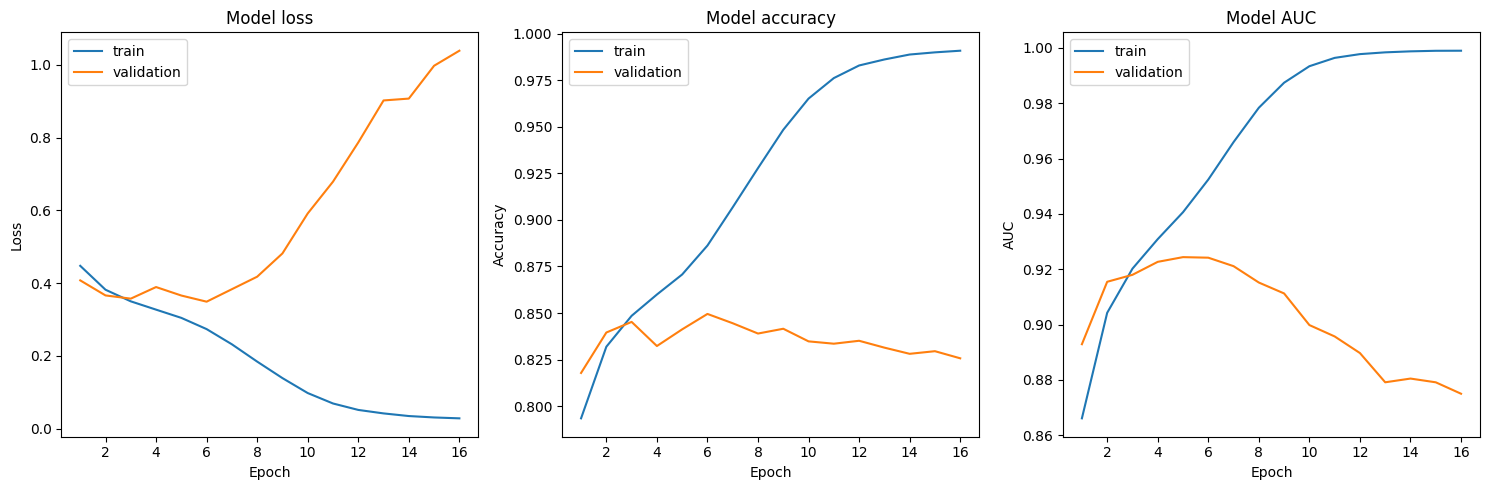

Best Epoch: 6
Best Model Loss: 0.348898708820343
Best Model Accuracy: 0.8495398163795471
Best Model AUC: 0.9241849184036255


In [17]:
conv_train_res = train_model(conv_model, train_generator, validation_generator, test_generator, "./conv_model", load_from_file=True, run_test=False)
print(f"Best Epoch: {conv_train_res[0]}")
print(f"Best Model Loss: {conv_train_res[1]}")
print(f"Best Model Accuracy: {conv_train_res[2]}")
print(f"Best Model AUC: {conv_train_res[3]}")

This optimization ran for 16 epochs, being ended by early stopping because the validation loss stopped improving after epoch 6, where it had a validation accuracy of 84.9% and an AUC of 0.92. Based on how the train and validation loss and AUC start to diverge from each other around epoch 6, there is very severe over fitting that started happening very early on and only got worse with every epoch. Despite this early over fitting, this convolutional model is 13.5% more accurate than the previous dense model, demonstrating the effectiveness of the convolutional neural network for this task. 

The test AUC from Kaggle is **0.7566**, which is a fair amount lower than the validation AUC of 0.849. This is further evidence that the model was starting to over fit even in epoch 6.   


In [18]:
results_df.loc[len(results_df.index)] = ["Convolutional", conv_train_res[1], conv_train_res[2], conv_train_res[3], 0.7566]

# Convolutional With Dropout

In order to try and remedy the early overfitting in the previous model, add some regularization in the form of a dropout layer before the second convolutional layer, before the dense hidden layer, and before the output. These drop out layers randomly set 50% of their inputs to zero, which helps prevent overfitting by creating a more robust model with more meaningful weights. Except for the dropout layers, the architecture is the same as the previous network. 

In [19]:
conv_dropout_model = Sequential()
conv_dropout_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
conv_dropout_model.add(MaxPooling2D((2, 2)))
conv_dropout_model.add(Dropout(0.5))
conv_dropout_model.add(Conv2D(32, (3, 3), activation='relu'))
conv_dropout_model.add(MaxPooling2D((2, 2)))
conv_dropout_model.add(Dropout(0.5))
conv_dropout_model.add(Flatten())
conv_dropout_model.add(Dense(128, activation="relu"))
conv_dropout_model.add(Dropout(0.5))
conv_dropout_model.add(Dense(1, activation="sigmoid"))

conv_dropout_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

conv_dropout_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 32)       

Loading Model from File


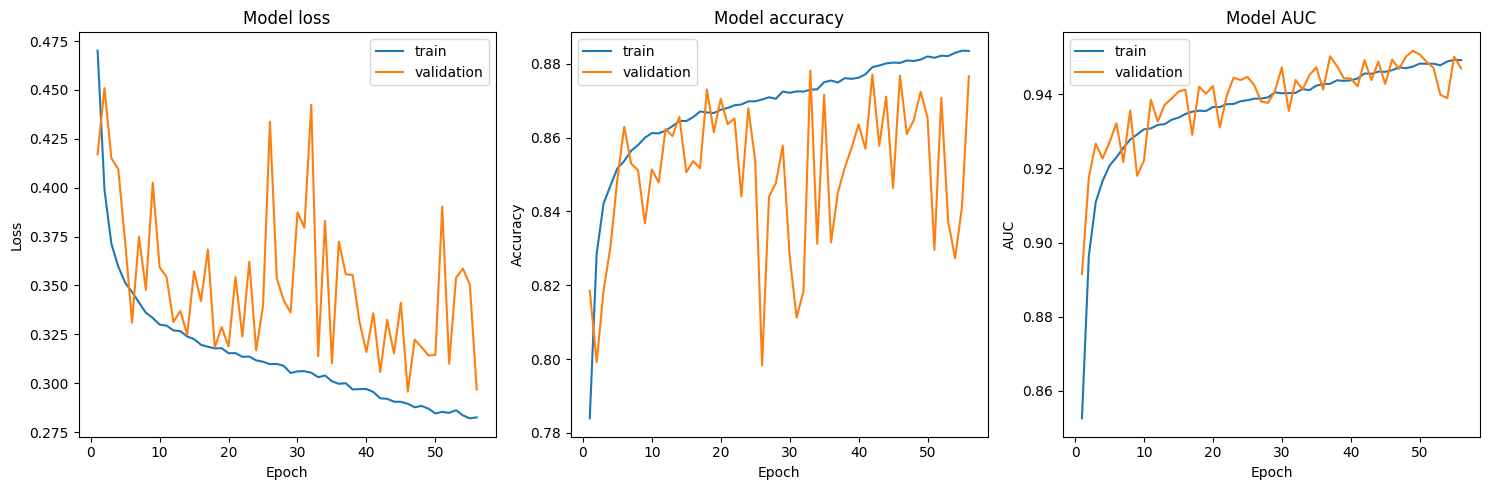

Best Epoch: 46
Best Model Loss: 0.29567575454711914
Best Model Accuracy: 0.8767867088317871
Best Model AUC: 0.9493325352668762


In [20]:
conv_dropout_train_res = train_model(conv_dropout_model, train_generator, validation_generator, test_generator, "./conv_dropout_model", load_from_file=True, run_test=False)
print(f"Best Epoch: {conv_dropout_train_res[0]}")
print(f"Best Model Loss: {conv_dropout_train_res[1]}")
print(f"Best Model Accuracy: {conv_dropout_train_res[2]}")
print(f"Best Model AUC: {conv_dropout_train_res[3]}")

This optimization ran for 56 epochs, being ended by early stopping because the validation loss stopped improving after epoch 46, where it had a validation accuracy of 87.6% and an AUC of 0.949. This model certainly did not overfit to the training data as early as the previous model but a new issue has appeared where the validation loss, accuracy, and AUC are extremely variable from epoch to epoch. Despite this issue, there is still an improvement of 1.8% in the validation accuracy from the previous model, showing that adding the dropout layers did help. 

The test AUC from Kaggle is **0.8001**, which is a fair amount lower than the validation AUC of 0.949, showing that there is still some over fitting going on.

In [21]:
results_df.loc[len(results_df.index)] = ["Convolutional Dropout Batch 32", conv_dropout_train_res[1], conv_dropout_train_res[2], conv_dropout_train_res[3], 0.8001]

# Tune Batch Size

In batch optimization like what is being used here, the gradient of the loss function with respect to each tunable weight is estimated at every step using only a subset of the total training data. So far 32 images has been the batch sized used to train all of the above models. However if this batch size is not large enough to be a statistically significant sample of the total training dataset, then these estimated gradients will be inaccurate. If the estimated gradients are inaccurate then there are two significant consequences. First, the model will both not optimize as much as it could every epoch and second, the model will not generalize as well to the validation or test data. 

In this case there are over 200k training images, so it is likely that the batch size of 32 has not been enough to get a statistically significant sample of the training data to estimate gradients with. This could explain the highly variable validation accuracy in the previous model, with the accuracy on the validation set at each epoch being tied to how well or poorly the gradient was estimated from the small batches.

Therefore the next step is to increase the batch size in order to better estimate the gradients at each step and hopefully produce less variable validation accuracy and a more robust model. To start with the batch size will be doubled to 64 and the same model as the previous one will be trained with this larger batch size. 

In [22]:
train_generator_64 = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary",
    subset="training"
)

validation_generator_64 = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=64,
    class_mode="binary",
    subset="validation"
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [23]:
conv_dropout_model_64 = Sequential()
conv_dropout_model_64.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
conv_dropout_model_64.add(MaxPooling2D((2, 2)))
conv_dropout_model_64.add(Dropout(0.5))
conv_dropout_model_64.add(Conv2D(32, (3, 3), activation='relu'))
conv_dropout_model_64.add(MaxPooling2D((2, 2)))
conv_dropout_model_64.add(Dropout(0.5))
conv_dropout_model_64.add(Flatten())
conv_dropout_model_64.add(Dense(128, activation="relu"))
conv_dropout_model_64.add(Dropout(0.5))
conv_dropout_model_64.add(Dense(1, activation="sigmoid"))

conv_dropout_model_64.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

conv_dropout_model_64.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 22, 22, 32)       

Loading Model from File


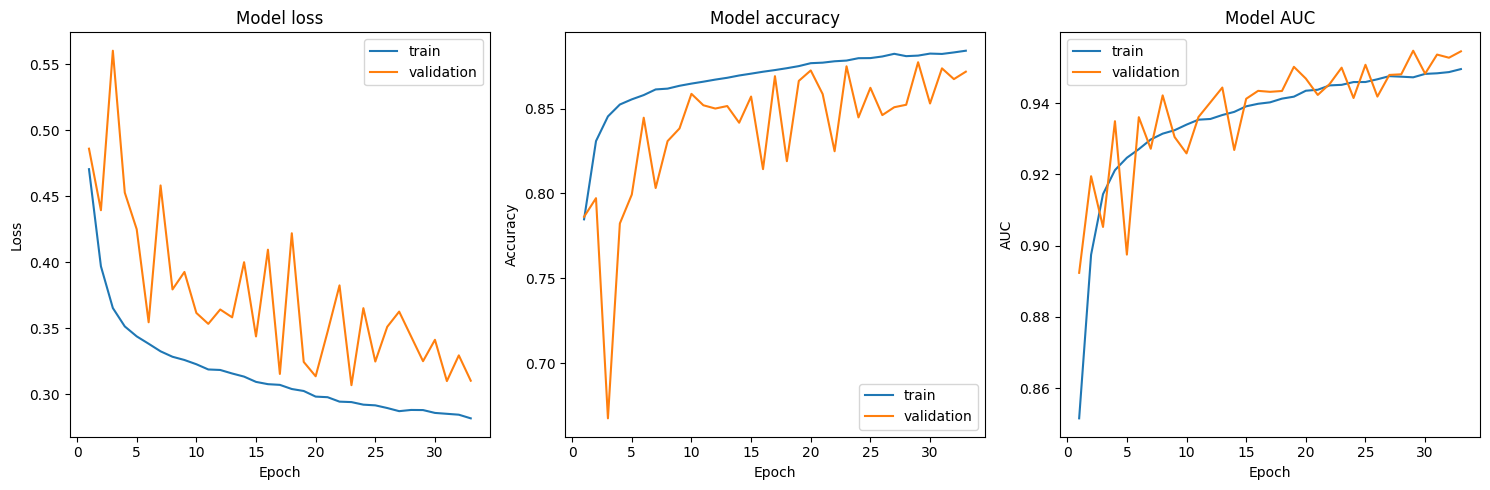

Best Epoch: 23
Best Model Loss: 0.306754469871521
Best Model Accuracy: 0.8749460577964783
Best Model AUC: 0.9499149918556213


In [24]:
conv_dropout_train_res_64 = train_model(conv_dropout_model_64, train_generator_64, validation_generator_64, test_generator, "./conv_dropout_64_model", load_from_file=True, run_test=False)
print(f"Best Epoch: {conv_dropout_train_res_64[0]}")
print(f"Best Model Loss: {conv_dropout_train_res_64[1]}")
print(f"Best Model Accuracy: {conv_dropout_train_res_64[2]}")
print(f"Best Model AUC: {conv_dropout_train_res_64[3]}")

This optimization ran for 33 epochs, being ended by early stopping because the validation loss stopped improving after epoch 23, where it had a validation accuracy of 87.5% and an AUC of 0.949. These are very similar results to the previous batch size of 32 and the validation accuracy is still highly variable. Despite this, there is now a more noticeable downward trend in the validation loss despite the variability, meaning that the larger batch size is starting to help. 

The test AUC from Kaggle is **0.8076**, which is a fair amount lower than the validation AUC of 0.949. It is however a little bit higher than the test AUC from when the batch size was 32, showing that this model generalizes to the test data a bit better. 

In [25]:
results_df.loc[len(results_df.index)] = ["Convolutional Dropout Batch 64", conv_dropout_train_res_64[1], conv_dropout_train_res_64[2], conv_dropout_train_res_64[3], 0.8076]

Next, double the batch size again from 64 to 128 and repeat the same process. 

In [26]:
train_generator_128 = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=128,
    class_mode="binary",
    subset="training"
)

validation_generator_128 = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=128,
    class_mode="binary",
    subset="validation"
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [27]:
conv_dropout_model_128 = Sequential()
conv_dropout_model_128.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
conv_dropout_model_128.add(MaxPooling2D((2, 2)))
conv_dropout_model_128.add(Dropout(0.5))
conv_dropout_model_128.add(Conv2D(32, (3, 3), activation='relu'))
conv_dropout_model_128.add(MaxPooling2D((2, 2)))
conv_dropout_model_128.add(Dropout(0.5))
conv_dropout_model_128.add(Flatten())
conv_dropout_model_128.add(Dense(128, activation="relu"))
conv_dropout_model_128.add(Dropout(0.5))
conv_dropout_model_128.add(Dense(1, activation="sigmoid"))

conv_dropout_model_128.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

conv_dropout_model_128.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 22, 22, 32)       

Loading Model from File


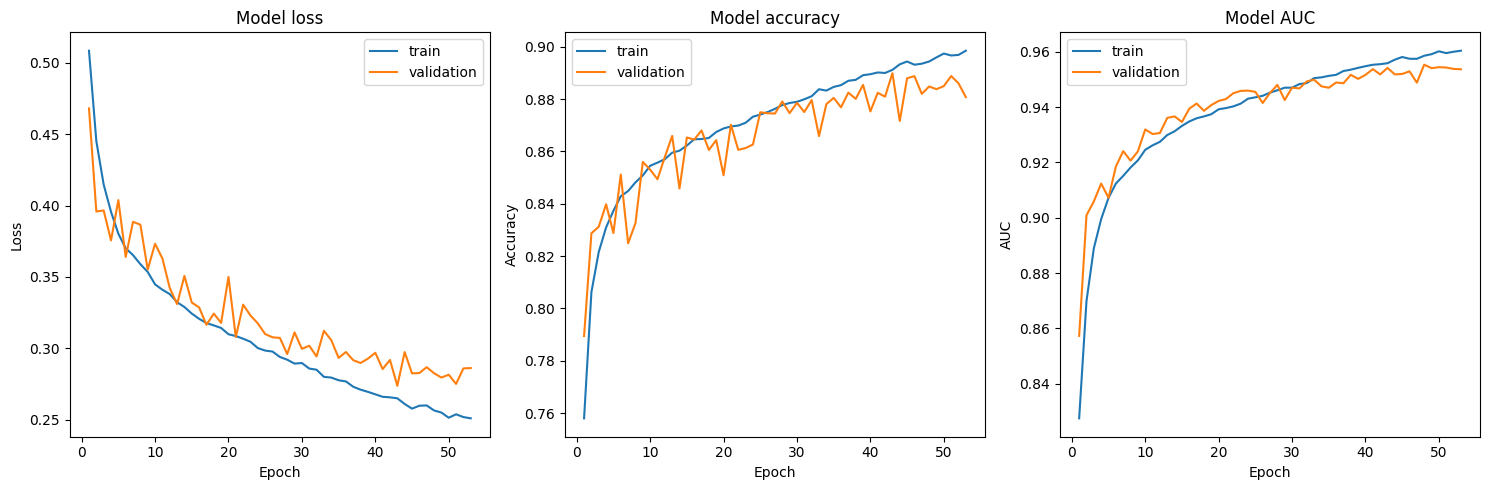

Best Epoch: 43
Best Model Loss: 0.2738211452960968
Best Model Accuracy: 0.8899216055870056
Best Model AUC: 0.9541759490966797


In [28]:
conv_dropout_train_res_128 = train_model(conv_dropout_model_128, train_generator_128, validation_generator_128, test_generator, "./conv_dropout_128_model", load_from_file=True, run_test=False)
print(f"Best Epoch: {conv_dropout_train_res_128[0]}")
print(f"Best Model Loss: {conv_dropout_train_res_128[1]}")
print(f"Best Model Accuracy: {conv_dropout_train_res_128[2]}")
print(f"Best Model AUC: {conv_dropout_train_res_128[3]}")

This optimization ran for 53 epochs, being ended by early stopping because the validation loss stopped improving after epoch 43, where it had a validation accuracy of 89% and an AUC of 0.954. These are slightly better results to the previous batch size of 64 and the validation accuracy is now much less variable highly variable, following the training results much more closely. This is starting to show that increasing the batch size is helping the model optimize and generalize 

The test AUC from Kaggle is **0.7979**, which is a fair amount lower than the validation AUC of 0.954. Despite this model visually fitting more closely to the training data, this is a slight decrease in test performance compared to the batch size of 64.

In [29]:
results_df.loc[len(results_df.index)] = ["Convolutional Dropout Batch 128", conv_dropout_train_res_128[1], conv_dropout_train_res_128[2], conv_dropout_train_res_128[3], 0.7979]

Finally, the batch size will be doubled one more time from 128 to 256

In [30]:
train_generator_256 = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=256,
    class_mode="binary",
    subset="training"
)

validation_generator_256 = datagen.flow_from_dataframe(
    dataframe=train_labels_df,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=256,
    class_mode="binary",
    subset="validation"
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [31]:
conv_dropout_model_256 = Sequential()
conv_dropout_model_256.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
conv_dropout_model_256.add(MaxPooling2D((2, 2)))
conv_dropout_model_256.add(Dropout(0.5))
conv_dropout_model_256.add(Conv2D(32, (3, 3), activation='relu'))
conv_dropout_model_256.add(MaxPooling2D((2, 2)))
conv_dropout_model_256.add(Dropout(0.5))
conv_dropout_model_256.add(Flatten())
conv_dropout_model_256.add(Dense(128, activation="relu"))
conv_dropout_model_256.add(Dropout(0.5))
conv_dropout_model_256.add(Dense(1, activation="sigmoid"))

conv_dropout_model_256.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

conv_dropout_model_256.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 22, 22, 32)       

Loading Model from File


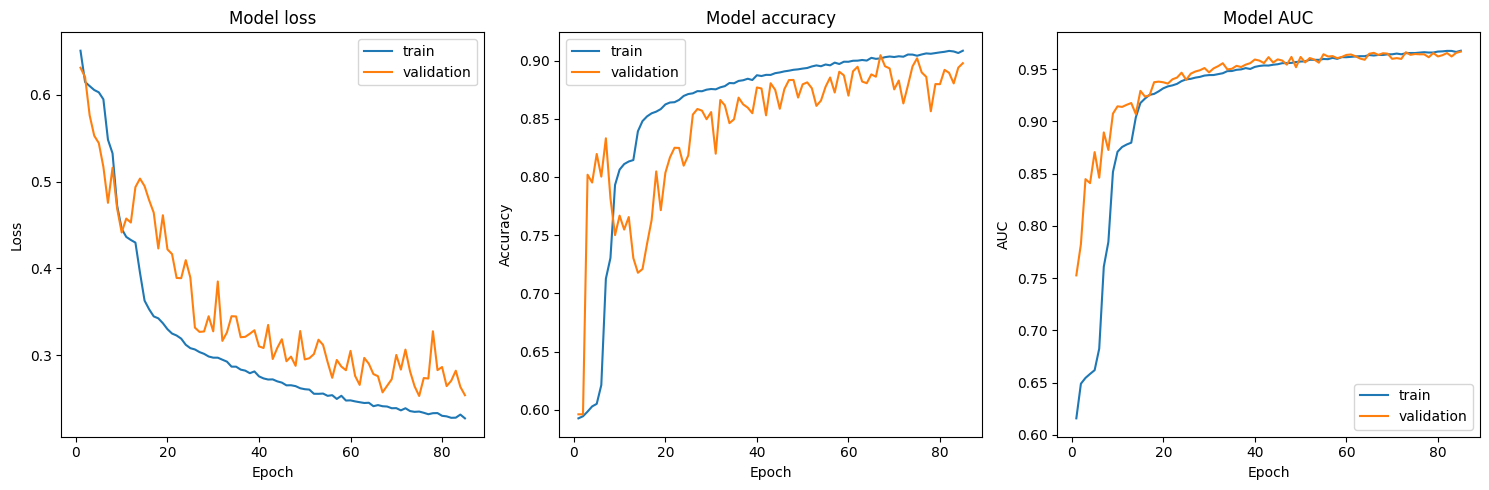

Best Epoch: 75
Best Model Loss: 0.2529274821281433
Best Model Accuracy: 0.9019429683685303
Best Model AUC: 0.9643415212631226


In [32]:
conv_dropout_train_res_256 = train_model(conv_dropout_model_256, train_generator_256, validation_generator_256, test_generator, "./conv_dropout_256_model", load_from_file=True, run_test=False)
print(f"Best Epoch: {conv_dropout_train_res_256[0]}")
print(f"Best Model Loss: {conv_dropout_train_res_256[1]}")
print(f"Best Model Accuracy: {conv_dropout_train_res_256[2]}")
print(f"Best Model AUC: {conv_dropout_train_res_256[3]}")

This optimization ran for 85 epochs, being ended by early stopping because the validation loss stopped improving after epoch 75, where it had a validation accuracy of 90.2% and an AUC of 0.964. Similar to the batch size of 128, this batch size of 256 leads to less variable validation metrics, especially AUC, which matches the train AUC very closely at later epochs. There did appear to be some instability between epochs 10 and 20, with the validation accuracy sharply falling before starting to increase again. It is also notable that this optimization ran for many more epochs than any other model before early stopping stopped it, indicating that the optimization was much more stable and gradual than previous models. 

The test AUC from Kaggle is **0.8246**, which is the best test AUC achieved. This demonstrates that increasing the batch size led to even better performance.

In [33]:
results_df.loc[len(results_df.index)] = ["Convolutional Dropout Batch 256", conv_dropout_train_res_256[1], conv_dropout_train_res_256[2], conv_dropout_train_res_256[3], 0.8246]

# Results

Below is the final results table comparing each of the created models and summarizing their validation loss, accuracy, and auc along with the test AUC

In [34]:
results_df

Model Name  Validation Loss  Validation Accuracy  \
0                            Dense         0.559766             0.714828   
1                    Convolutional         0.348899             0.849540   
2   Convolutional Dropout Batch 32         0.295676             0.876787   
3   Convolutional Dropout Batch 64         0.306754             0.874946   
4  Convolutional Dropout Batch 128         0.273821             0.889922   
5  Convolutional Dropout Batch 256         0.252927             0.901943   

   Validation AUC  Test AUC  
0        0.775817    0.6600  
1        0.924185    0.7566  
2        0.949333    0.8001  
3        0.949915    0.8076  
4        0.954176    0.7979  
5        0.964342    0.8246

To better visualize all of these metrics and how they compare for each model, create some bar charts

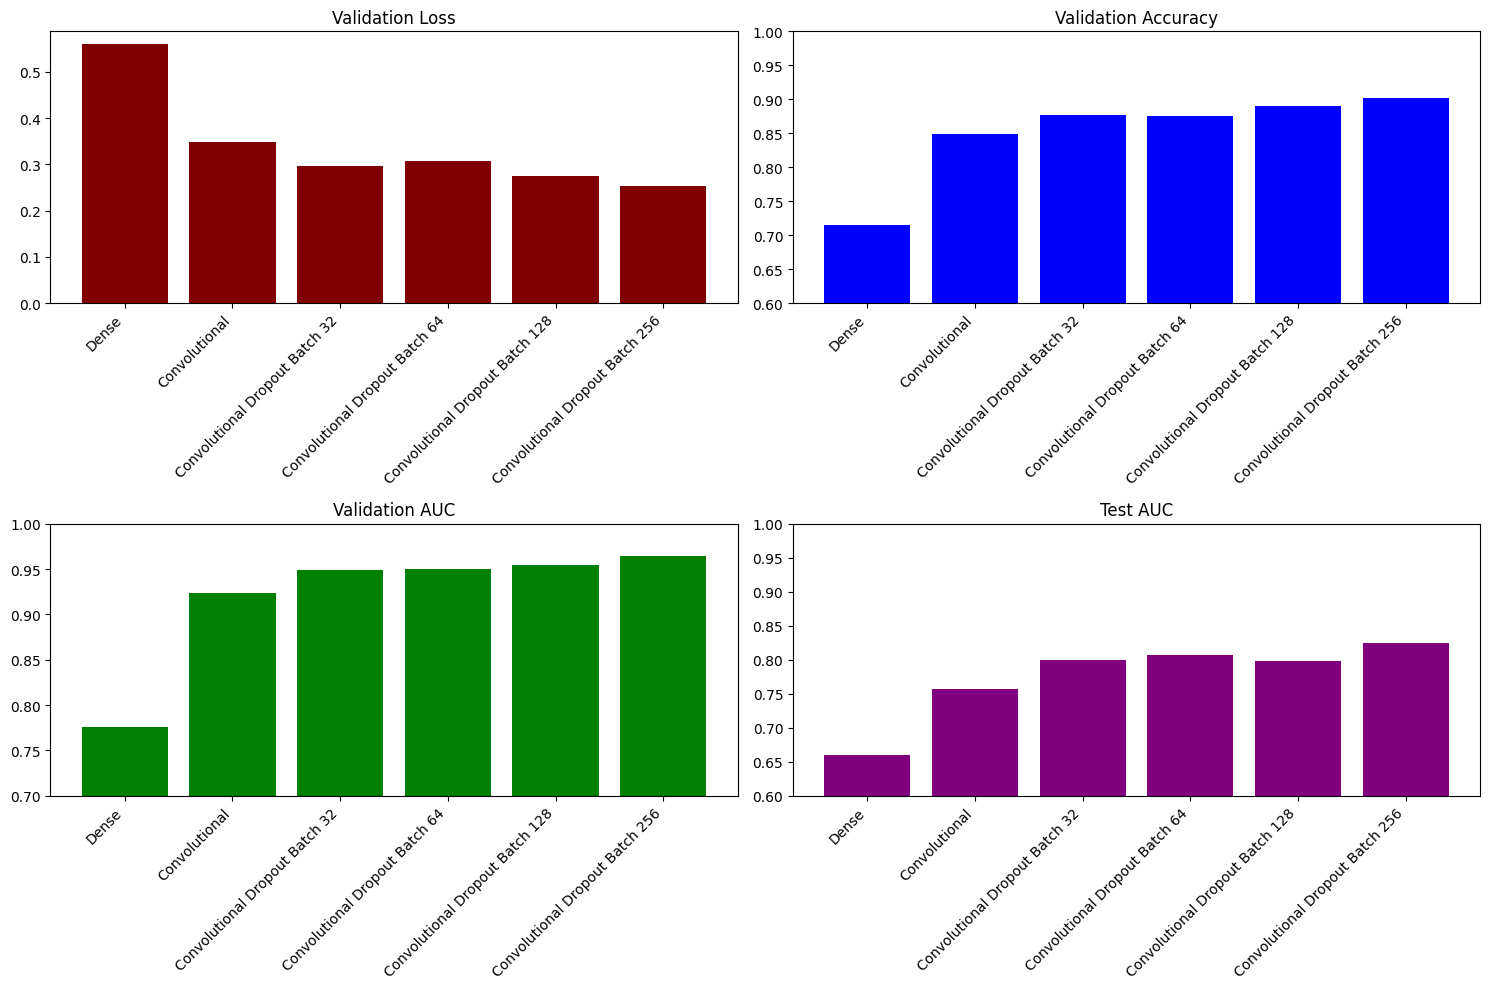

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Validation Loss bar chart
axs[0, 0].bar(results_df['Model Name'], results_df['Validation Loss'], color ='maroon')
axs[0, 0].set_title('Validation Loss')
axs[0, 0].set_xticks(range(len(results_df['Model Name'])))
axs[0, 0].set_xticklabels(results_df['Model Name'], rotation=45, ha='right')

# Validation Accuracy bar chart
axs[0, 1].bar(results_df['Model Name'], results_df['Validation Accuracy'], color ='blue')
axs[0, 1].set_title('Validation Accuracy')
axs[0, 1].set_xticks(range(len(results_df['Model Name'])))
axs[0, 1].set_xticklabels(results_df['Model Name'], rotation=45, ha='right')
axs[0, 1].set_ylim(0.6, 1)

# Validation AUC bar chart
axs[1, 0].bar(results_df['Model Name'], results_df['Validation AUC'], color ='green')
axs[1, 0].set_title('Validation AUC')
axs[1, 0].set_xticks(range(len(results_df['Model Name'])))
axs[1, 0].set_xticklabels(results_df['Model Name'], rotation=45, ha='right')
axs[1, 0].set_ylim(0.7, 1)

# Test AUC bar chart
axs[1, 1].bar(results_df['Model Name'], results_df['Test AUC'], color ='purple')
axs[1, 1].set_title('Test AUC')
axs[1, 1].set_xticks(range(len(results_df['Model Name'])))
axs[1, 1].set_xticklabels(results_df['Model Name'], rotation=45, ha='right')
axs[1, 1].set_ylim(0.6, 1)

plt.tight_layout()
plt.show()

Observation about each model based on these results:
* The dense model was by far the worst performing model across all metrics. This makes sense as a dense, fully connected neural network is not well suited for this task, but does form a good baseline to compare other models to. 
* The first convolutional model with no dropout performed significantly better than the dense model, but still worse than all of the later convolutional models accross all metrics
* Adding dropout to the convolutional model improved it accross all metrics. 
* When tuning the batch size hyperparameter, it was not the case that the model improved across all metrics for each new, larger batch size. Batch size 64 had a slightly higher loss and AUC than batch size 32.
* Across all metrics the best model was the convolutional model with dropout and a batch size of 256

# Conclusion

In this project, several neural network models were created in order to classify 96x96 RGB images of tissue as either cancerous or non-cancerous. First a dense, single hidden layer network was trained that did not perform very well. Next, a simple convolutional model was trained which performed much better than the dense model but was found to over fit easily to the training data. 

To address this over fitting, the third model added dropout layers to regularize the weights of the model and prevent over fitting, this exposed the issue of highly variable validation metrics. In order to correct the highly variable validation metrics, the hyperparameter of batch size was tuned with values of 32, 64, 128, and 256 being tried. The best performing model in the end was the convolutional model with dropout trained with a batch size of 256, which achieved a test AUC of **0.8246**.

There are several ways that this model could be extended and improved even further.
* The best performing convolutional models still only had two convolutional layers and one fully connected hidden layer. It is likely that by making this neural network even deeper, with more convolutional and max pooling layers, that even more complex features could be found that lead to even better model performance.
* Only one hyperparameter, the batch size, was tuned in order to correct the issue of highly variable validation metrics. There are many more hyperpareters in the model however such as the learning rate, the kernel sizes, the number of hidden layers, or the pooling layer sizes to name a few. Further hyperparameter tuning could be performed on some of these to further improve the model. 